# Prediction of Housing Prices


*Authors: Eric Luong, David Chien, Michelle Zhang*  
*Data: Ames Housing Dataset from Kaggle*  

Time flies! You have now learned and (hopefully) mastered all the skills required to build a real-world ML regression model! These skills include:

- Exploratory data analysis (EDA)
- Data pre-processing and feature engineering: scaling, imputation, encoding...
- A suite of regression models: linear regression, trees, forests, ...
- Hyperparamter tuning: CV, GridSearch...
- Model evaluation

Now it is time to deploy these skills in the real world, build your first "real" ML project, and see how you perform against other data scientists from all over the world!

We will join this active Kaggle competition to predict house prices:


https://www.kaggle.com/c/house-prices-advanced-regression-techniques

You will find the detailed description of the competition from above web site, and can download the data directly there. 

**Requirements:**

- Please use this notebook to create your code, explanation, graphs, and results just like what you did for your homework.
- Each group should create a Kaggle account and submit the prediction of your model in Kaggle. Please add "SCU_" in front of your team name so that you can check how you rank among your classmates in the Leaderboard. However, you do not have to use your real name in your team name.
- You can submit your results multiple times in Kaggle. Therefore you are encouraged to submit your model, improve, then re-submit. It is a continuous learning process.
- **Please include a screenshot of your best Kaggle submission at the bottom of this notebook showing your rank and score in the leaderboard.**
- You are also encouraged to read discussion forums to learn and get your inspiration, but code copying is strictly forbidden.
- **Honor code: again, you cannot copy code. We will check your code and you will be asked to present in class (so you need to be extremely familiar with your work)!**

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
import optuna
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Load train and test data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")


## Exploratory Data Analysis

In [3]:
# Check for missing values
train_data.isnull().sum().sort_values(ascending=False).head(20) 

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

### Histogram for Skewness

Text(0.5, 1.0, 'SalePrice distribution')

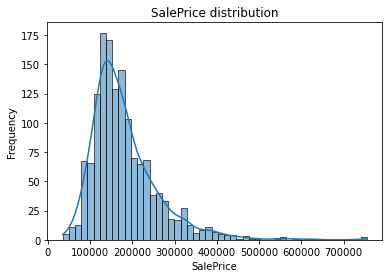

In [4]:
# Check the new distribution 
sns.histplot(train_data['SalePrice'], kde=True)

plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

In [5]:
# Skew and kurt
print("Skewness: %f" % train_data['SalePrice'].skew())
print("Kurtosis: %f" % train_data['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


Since the target variable is skewed, we will apply log transformation to it. This will help us to get a normal distribution of the target variable.

Text(0.5, 1.0, 'SalePrice distribution')

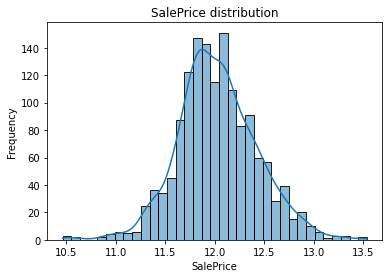

In [6]:
# Log-transform the target variable
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])

# Check the new distribution 
sns.histplot(train_data['SalePrice'], kde=True)

plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

### Correlation Matrix

<AxesSubplot:>

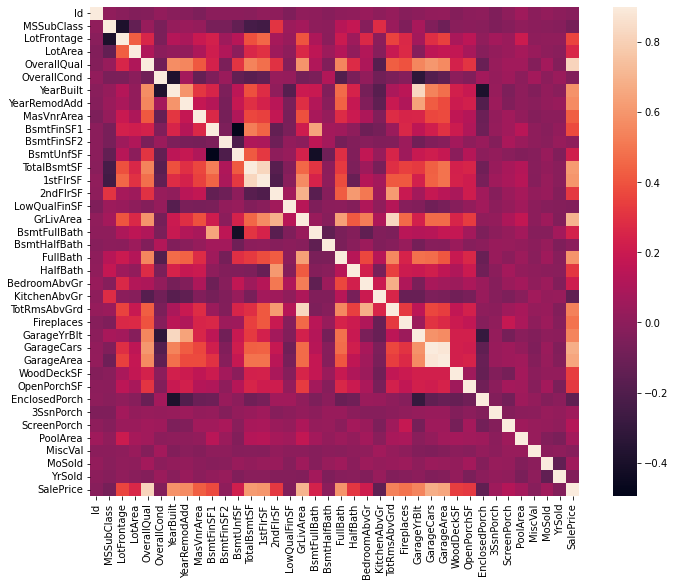

In [7]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train_data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

<AxesSubplot:>

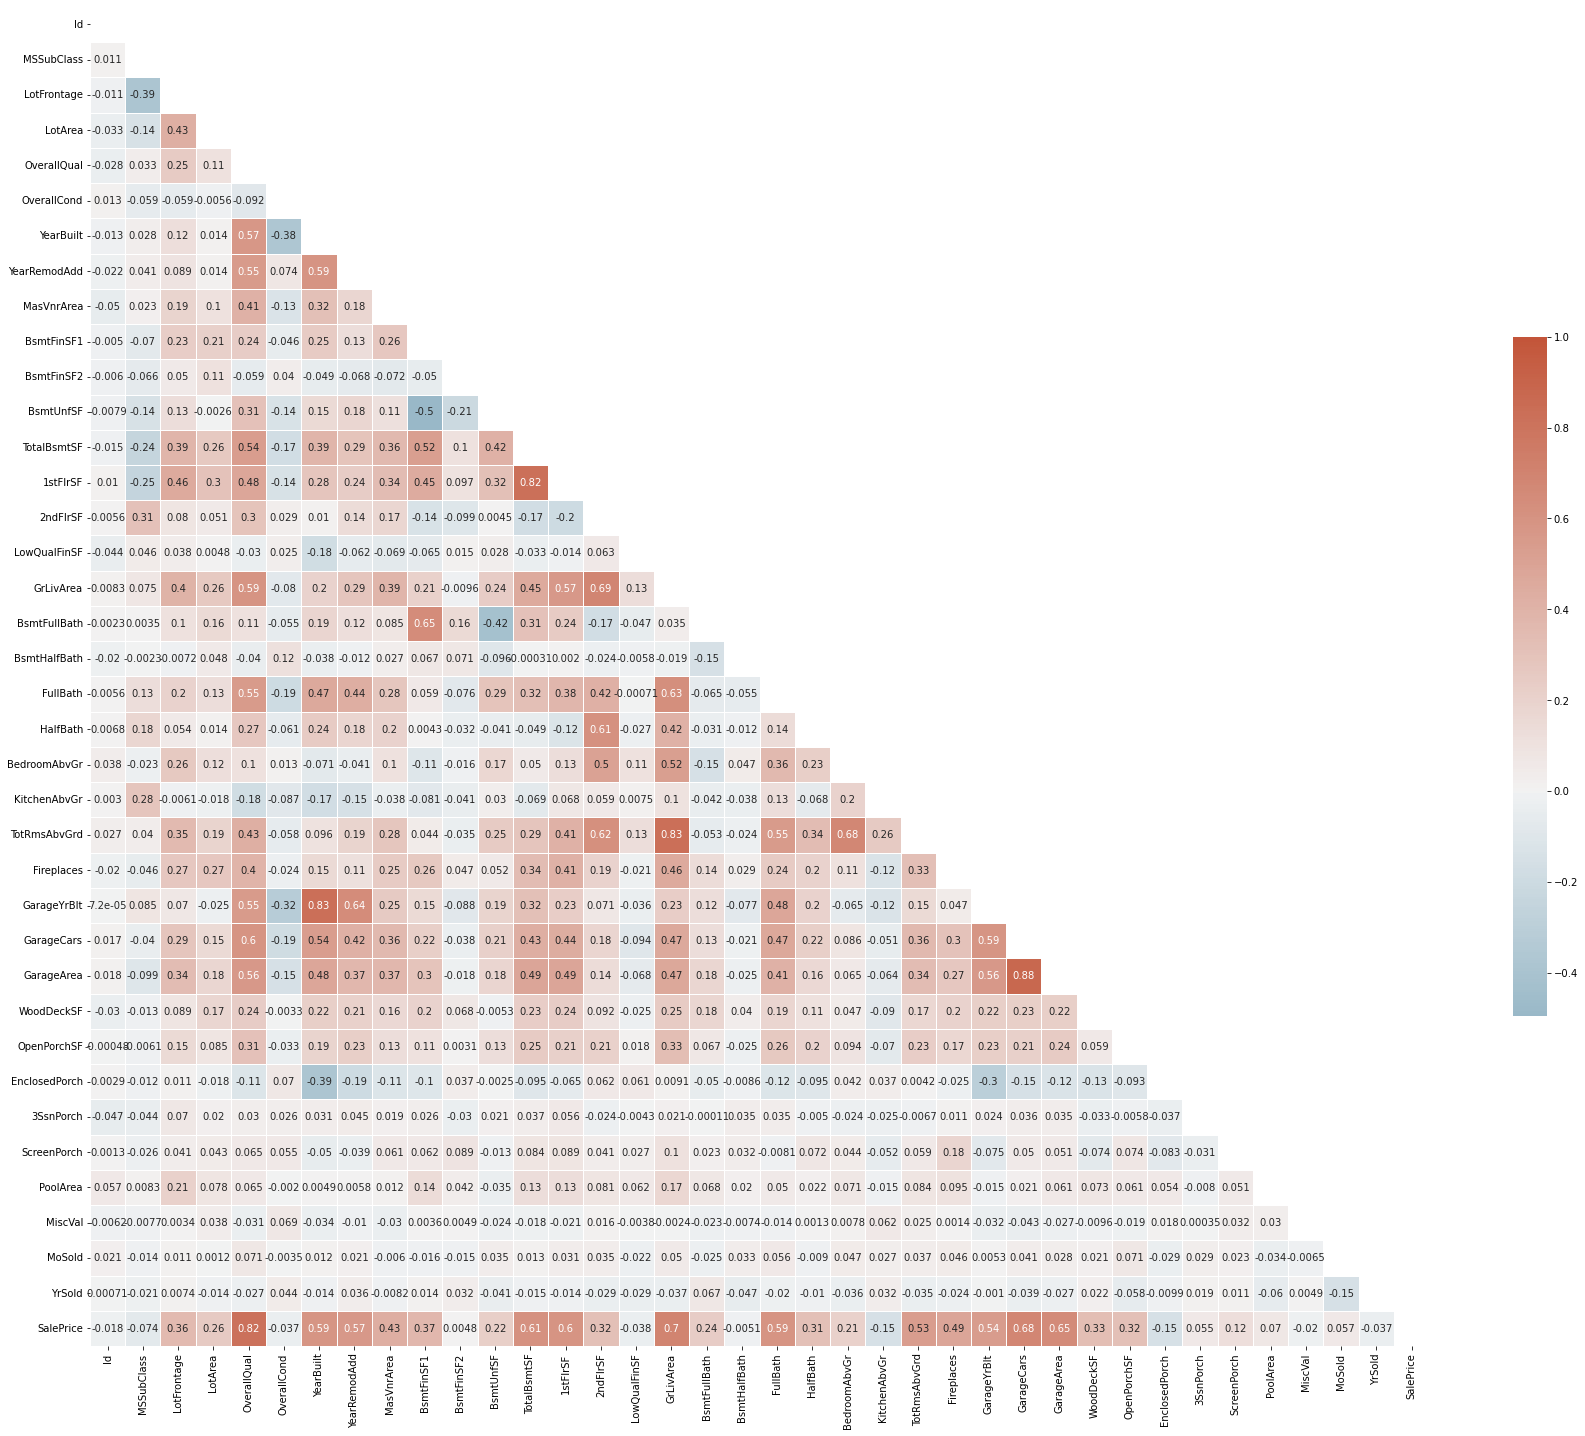

In [8]:
# Correlation Matrix

f, ax = plt.subplots(figsize=(30, 25))
mat = train_data.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Analyzing Correlations

In [9]:
correlations = train_data.corr()["SalePrice"].abs().sort_values(ascending = False)
correlations.head()

SalePrice      1.000000
OverallQual    0.817185
GrLivArea      0.700927
GarageCars     0.680625
GarageArea     0.650888
Name: SalePrice, dtype: float64

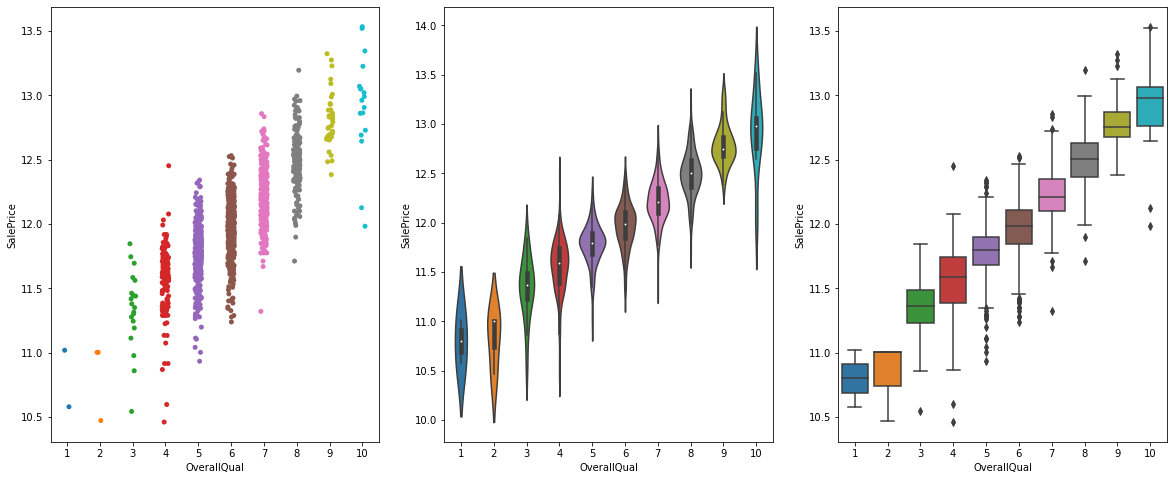

In [10]:
# OverallQuall - SalePrice [corr = 0.82]

figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=train_data, x = 'OverallQual', y='SalePrice', ax = ax[0])
sns.violinplot(data=train_data, x = 'OverallQual', y='SalePrice', ax = ax[1])
sns.boxplot(data=train_data, x = 'OverallQual', y='SalePrice', ax = ax[2])
plt.show()

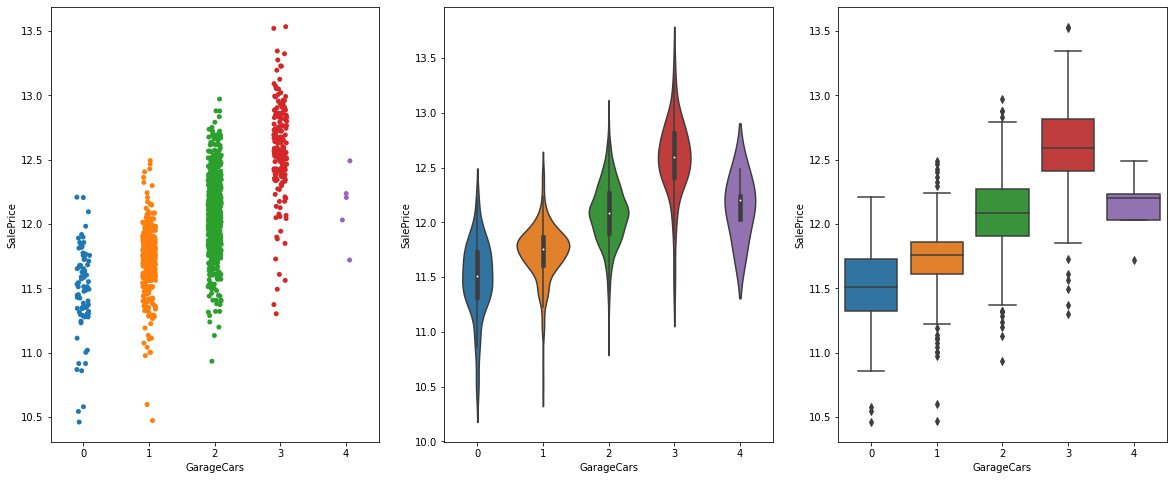

In [11]:
# GarageCars - SalePrice [corr = 0.68]

figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=train_data, x = 'GarageCars', y='SalePrice', ax = ax[0])
sns.violinplot(data=train_data, x = 'GarageCars', y='SalePrice', ax = ax[1])
sns.boxplot(data=train_data, x = 'GarageCars', y='SalePrice', ax = ax[2])
plt.show()

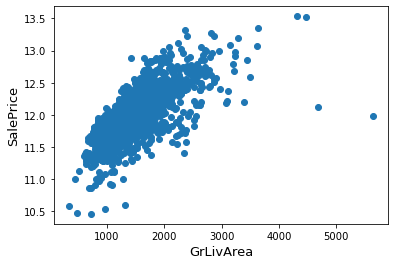

In [12]:
# GrLivArea - SalePrice [corr = 0.7]
fig, ax = plt.subplots()
ax.scatter(x = train_data['GrLivArea'], y = train_data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

## Regression Analysis: Using RandomSearchCV

#### Feature Engineering

In [13]:
# Feature Engineering
train_data['TotalSF'] = train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF']
train_data['Bathrooms'] = train_data['FullBath'] + train_data['HalfBath'] * 0.5
train_data['YearAverage'] = (train_data['YearBuilt'] + train_data['YearRemodAdd']) / 2

# Feature Engineering Test Data
test_data['TotalSF'] = test_data['TotalBsmtSF'] + test_data['1stFlrSF'] + test_data['2ndFlrSF']
test_data['Bathrooms'] = test_data['FullBath'] + test_data['HalfBath'] * 0.5
test_data['YearAverage'] = (test_data['YearBuilt'] + test_data['YearRemodAdd']) / 2

In [14]:
# Clean train and test data
def clean_data(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    for col in df.columns:
        if df[col].isna().any() and np.issubdtype(df[col].dtype, np.number):
            df[col].fillna(df[col].median(), inplace=True)

clean_data(train_data)
clean_data(test_data)


In [15]:
# Define the column transformer
numeric_features = train_data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = train_data.select_dtypes(include=['object']).columns

# Update numerical_transformer
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Update categorical_transformer
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define columns to be dropped
drop_columns = ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']

# Remove drop_columns from numeric_features and categorical_features
numeric_features = [col for col in numeric_features if col not in drop_columns and col != 'SalePrice']
categorical_features = [col for col in categorical_features if col not in drop_columns]

# Feature Interaction
interaction_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('interaction', interaction_transformer, numeric_features)
    ])

In [16]:
# Model Stacking
estimators = [
    ('lgbm', LGBMRegressor(n_estimators=100, max_depth=3)),
    ('xgb', XGBRegressor(n_estimators=100, max_depth=3)),
    ('gbr', GradientBoostingRegressor(n_estimators=100, max_depth=3)),
    ('rfr', RandomForestRegressor(n_estimators=100, max_depth=3)),
    ('catboost', CatBoostRegressor(iterations=100, depth=4, learning_rate=0.1, silent=True))
]

stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(alphas=np.logspace(-3, 3, 10))
)

In [17]:
# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', stacking_regressor)
])

# Separate the train_data into training and validation sets
X = train_data.drop(['Id', 'SalePrice'], axis=1)
y = train_data['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Define objective function for Bayesian optimization
def objective(trial):
    n_estimators_lgbm = trial.suggest_int("n_estimators_lgbm", 50, 150)
    max_depth_lgbm = trial.suggest_int("max_depth_lgbm", 2, 4)
    
    n_estimators_xgb = trial.suggest_int("n_estimators_xgb", 50, 150)
    max_depth_xgb = trial.suggest_int("max_depth_xgb", 2, 4)
    
    n_estimators_gbr = trial.suggest_int("n_estimators_gbr", 50, 150)
    max_depth_gbr = trial.suggest_int("max_depth_gbr", 2, 4)
    
    n_estimators_rfr = trial.suggest_int("n_estimators_rfr", 50, 150)
    max_depth_rfr = trial.suggest_int("max_depth_rfr", 2, 4)
    
    iterations_catboost = trial.suggest_int("iterations_catboost", 50, 150)
    depth_catboost = trial.suggest_int("depth_catboost", 2, 4)
    
    pipeline.set_params(regressor__lgbm__n_estimators=n_estimators_lgbm, regressor__lgbm__max_depth=max_depth_lgbm,
                        regressor__xgb__n_estimators=n_estimators_xgb, regressor__xgb__max_depth=max_depth_xgb,
                        regressor__gbr__n_estimators=n_estimators_gbr, regressor__gbr__max_depth=max_depth_gbr,
                        regressor__rfr__n_estimators=n_estimators_rfr, regressor__rfr__max_depth=max_depth_rfr,
                        regressor__catboost__iterations=iterations_catboost, regressor__catboost__depth=depth_catboost)
    
    pipeline.fit(X_train, y_train)
    y_val_pred = pipeline.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    return rmse



In [18]:
# Perform Bayesian optimization using Optuna
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

# Predict on the validation data using the best estimator
y_val_pred = pipeline.predict(X_val)

# Calculate RMSE and R^2 on the validation set
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2 = r2_score(y_val, y_val_pred)

print("RMSE:", rmse)
print("R^2:", r2)

[I 2023-03-15 14:52:51,892] A new study created in memory with name: no-name-a75aa39a-27da-4d53-ba40-eae69ddbc35f
[I 2023-03-15 14:53:39,251] Trial 0 finished with value: 0.1313611843619157 and parameters: {'n_estimators_lgbm': 87, 'max_depth_lgbm': 4, 'n_estimators_xgb': 123, 'max_depth_xgb': 3, 'n_estimators_gbr': 65, 'max_depth_gbr': 2, 'n_estimators_rfr': 55, 'max_depth_rfr': 4, 'iterations_catboost': 110, 'depth_catboost': 4}. Best is trial 0 with value: 0.1313611843619157.
[I 2023-03-15 14:54:24,773] Trial 1 finished with value: 0.13147350369984903 and parameters: {'n_estimators_lgbm': 52, 'max_depth_lgbm': 4, 'n_estimators_xgb': 134, 'max_depth_xgb': 2, 'n_estimators_gbr': 68, 'max_depth_gbr': 2, 'n_estimators_rfr': 80, 'max_depth_rfr': 3, 'iterations_catboost': 93, 'depth_catboost': 2}. Best is trial 0 with value: 0.1313611843619157.
[I 2023-03-15 14:55:35,886] Trial 2 finished with value: 0.132563753097371 and parameters: {'n_estimators_lgbm': 111, 'max_depth_lgbm': 2, 'n_esti

RMSE: 0.13088278458324482
R^2: 0.9082031372868952


In [19]:
# Print best parameters
print(study.best_params)

{'n_estimators_lgbm': 87, 'max_depth_lgbm': 4, 'n_estimators_xgb': 109, 'max_depth_xgb': 2, 'n_estimators_gbr': 51, 'max_depth_gbr': 2, 'n_estimators_rfr': 146, 'max_depth_rfr': 4, 'iterations_catboost': 145, 'depth_catboost': 4}


## Predict 'SalePrice' using Test Data

We first need to preprocess test_data in the same way we did for train_data. We can do this by using the same pipeline and dropping strategy as before.

In [21]:
# Get the best parameters from the Optuna study
best_params = study.best_params

# Update the pipeline with the best parameters
regressors = [
    ("lgbm", LGBMRegressor(n_estimators=best_params["n_estimators_lgbm"], max_depth=best_params["max_depth_lgbm"])),
    ("xgb", XGBRegressor(n_estimators=best_params["n_estimators_xgb"], max_depth=best_params["max_depth_xgb"])),
    ("gbr", GradientBoostingRegressor(n_estimators=best_params["n_estimators_gbr"], max_depth=best_params["max_depth_gbr"])),
    ("rfr", RandomForestRegressor(n_estimators=best_params["n_estimators_rfr"], max_depth=best_params["max_depth_rfr"])),
    ("catboost", CatBoostRegressor(iterations=best_params["iterations_catboost"], depth=best_params["depth_catboost"]))
]
stacking_regressor = StackingRegressor(estimators=regressors, final_estimator=RidgeCV())

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', stacking_regressor)
])

# Fit the pipeline on the entire training dataset
pipeline.fit(X, y)

# Prepare the test_data
X_test = test_data.drop(['Id'], axis=1)

# Predict on the test data using the best estimator
y_test_pred = pipeline.predict(X_test)

# Apply the inverse log transformation to the predicted 'SalePrice' values
y_test_pred_original_scale = np.expm1(y_test_pred)

Learning rate set to 0.208908
0:	learn: 0.3459148	total: 12.1ms	remaining: 1.75s
1:	learn: 0.3045914	total: 18.6ms	remaining: 1.33s
2:	learn: 0.2719977	total: 25.6ms	remaining: 1.21s
3:	learn: 0.2421331	total: 31.1ms	remaining: 1.1s
4:	learn: 0.2211252	total: 36.9ms	remaining: 1.03s
5:	learn: 0.2032210	total: 42.7ms	remaining: 990ms
6:	learn: 0.1896332	total: 48ms	remaining: 945ms
7:	learn: 0.1779577	total: 53.1ms	remaining: 909ms
8:	learn: 0.1699360	total: 58ms	remaining: 877ms
9:	learn: 0.1624545	total: 63.7ms	remaining: 861ms
10:	learn: 0.1564433	total: 68.8ms	remaining: 838ms
11:	learn: 0.1507119	total: 74ms	remaining: 820ms
12:	learn: 0.1460783	total: 79.2ms	remaining: 804ms
13:	learn: 0.1423010	total: 84.2ms	remaining: 788ms
14:	learn: 0.1393392	total: 89.3ms	remaining: 774ms
15:	learn: 0.1363300	total: 94.9ms	remaining: 765ms
16:	learn: 0.1335672	total: 100ms	remaining: 754ms
17:	learn: 0.1312230	total: 106ms	remaining: 745ms
18:	learn: 0.1295211	total: 111ms	remaining: 735ms
19

## Create Submission File

In [22]:
# Create the submission DataFrame
submission = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': y_test_pred_original_scale})

# Save the submission DataFrame to a CSV file
submission.to_csv('submission_V3.csv', index=False)

### Screenshot of Best Kaggle Submission

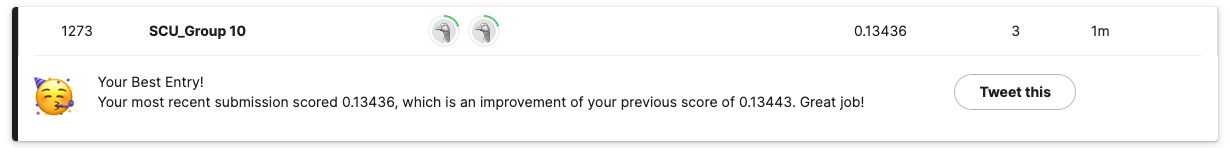

In [ ]:
from IPython.display import Image
Image(filename = 'kaggle_screenshot.png')